## Time Series Challenge
In this challenge, we will compare the various time series prediction techniques on the dataset we can find [here](https://drive.google.com/file/d/1pgZlxluv5_cbgwR5JSWu4njbYXo_06Eb/view?usp=sharing).

- moving average
- ARIMA
- Prophet
- (Stretch) LSTMs

There are several item categories in this sales dataset. You can choose your own category or predict the overall sales.

> #### Note
> We have one order in every row, thus don't forget to transform the data into a time series format first. The data can be transformed into a daily, weekly or monthly time series.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error

In [7]:
data = pd.read_excel('data/superstore.xls', index_col=0).reset_index(drop=True)
data

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Order Date     9994 non-null   datetime64[ns]
 2   Ship Date      9994 non-null   datetime64[ns]
 3   Ship Mode      9994 non-null   object        
 4   Customer ID    9994 non-null   object        
 5   Customer Name  9994 non-null   object        
 6   Segment        9994 non-null   object        
 7   Country        9994 non-null   object        
 8   City           9994 non-null   object        
 9   State          9994 non-null   object        
 10  Postal Code    9994 non-null   int64         
 11  Region         9994 non-null   object        
 12  Product ID     9994 non-null   object        
 13  Category       9994 non-null   object        
 14  Sub-Category   9994 non-null   object        
 15  Product Name   9994 n

In [24]:
# Office supplies are the largest category, let's focus on this one

data['Category'].value_counts()

supplies = data[data['Category'] == 'Office Supplies']

supplies_series = pd.concat([supplies['Order Date'], supplies['Sales']], axis=1)

supplies_series

,Order Date,Sales
2,2016-06-12,14.620
4,2015-10-11,22.368
6,2014-06-09,7.280
8,2014-06-09,18.504
9,2014-06-09,114.900
...,...,...
9982,2016-09-22,35.560
9984,2015-05-17,31.500
9985,2015-05-17,55.600
9992,2017-02-26,29.600


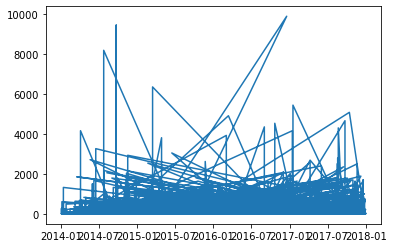

In [26]:
# We want to predict the Sales amount, let's look at the sales over time

plt.plot(supplies['Order Date'], supplies['Sales'])
plt.show()

In [30]:
# There are multiple values by day, let's resample

daily_supplies = supplies.resample('D', on='Order Date').sum()
daily_supplies

,Postal Code,Sales,Quantity,Discount,Profit
Order Date,,,,,
2014-01-03,77095,16.448,2,0.2,5.5512
2014-01-04,181620,288.060,8,1.2,-65.9901
2014-01-05,19143,19.536,3,0.2,4.8840
2014-01-06,290334,685.340,15,0.0,293.8612
2014-01-07,77340,10.430,7,0.8,-18.2525
...,...,...,...,...,...
2017-12-26,243617,814.594,12,0.9,61.1202
2017-12-27,43055,13.248,4,0.2,3.6432
2017-12-28,672615,1091.244,44,2.1,298.7773


<AxesSubplot:xlabel='Order Date'>

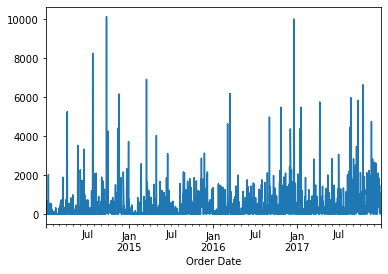

In [31]:
# A little better, let's get the moving average next
daily_supplies['Sales'].plot()

Order Date
2014-01-09    147.022571
2014-01-10    145.085714
2014-01-11    103.934286
2014-01-12    101.143429
2014-01-13    292.825714
2014-01-14    291.335714
2014-01-15    291.335714
2014-01-16    296.952286
2014-01-17    296.539429
2014-01-18    305.805714
2014-01-19    333.966286
2014-01-20    124.439714
2014-01-21    124.439714
2014-01-22    124.439714
2014-01-23    124.062571
2014-01-24    124.062571
2014-01-25    114.796286
2014-01-26    163.310000
2014-01-27     96.630000
2014-01-28     97.191143
2014-01-29     97.191143
2014-01-30    124.974000
2014-01-31    124.974000
2014-02-01    124.974000
2014-02-02     52.683429
2014-02-03     53.175143
2014-02-04     71.811714
2014-02-05     71.811714
2014-02-06     40.876286
2014-02-07     50.156286
2014-02-08     50.156286
2014-02-09     45.772571
2014-02-10     31.899429
2014-02-11     35.401714
2014-02-12     35.401714
2014-02-13     31.980000
2014-02-14     70.808000
2014-02-15     73.859429
2014-02-16     75.150857
2014-02-17    

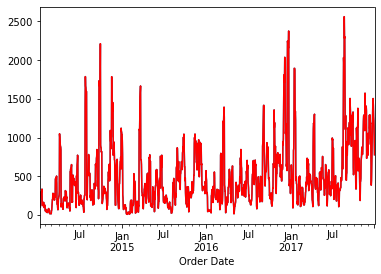

In [68]:
# Tail-rolling average transform
rolling = daily_supplies['Sales'].rolling(window=7)
rolling_mean = rolling.mean().dropna()
print(rolling_mean.head(60))
# plot original and transformed dataset
rolling_mean.plot()
rolling_mean.plot(color='red')
plt.show()

# Moving Average

predicted=161.702667, expected=30.686000
predicted=162.177267, expected=97.112000
predicted=155.812333, expected=134.384000
predicted=159.640600, expected=0.000000
predicted=136.795933, expected=23.952000
predicted=137.246667, expected=64.960000
predicted=139.412000, expected=0.000000
predicted=139.100533, expected=0.000000
predicted=139.004200, expected=0.000000
predicted=139.004200, expected=158.900000
predicted=144.300867, expected=0.000000
predicted=76.730333, expected=0.000000
predicted=76.730333, expected=336.756000
predicted=87.955533, expected=21.360000
predicted=87.045533, expected=9.040000
predicted=87.346867, expected=54.208000
predicted=86.991667, expected=12.624000
predicted=80.841667, expected=0.000000
predicted=62.160667, expected=12.960000
predicted=62.592667, expected=8.850000
predicted=62.887667, expected=19.440000
predicted=62.001667, expected=11.364000
predicted=62.380467, expected=55.672000
predicted=64.236200, expected=0.000000
predicted=46.345533, expected=0.0000

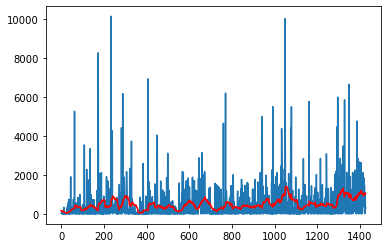

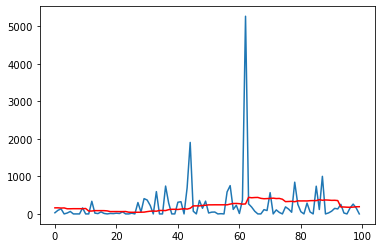

In [100]:
# Let's predict the daily value with the 30-day average
# prepare situation
X = daily_supplies['Sales'].values
window = 30
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
	length = len(history)
	yhat = np.mean([history[i] for i in range(length-window,length)])
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
# zoom plot
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red')
plt.show()


The error is very high, this method is not suitable

# ARIMA

Order Date
2014-01-09    147.022571
2014-01-10    145.085714
2014-01-11    103.934286
2014-01-12    101.143429
2014-01-13    292.825714
Freq: D, Name: Sales, dtype: float64


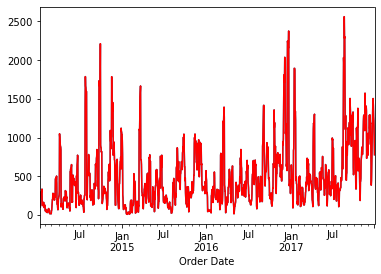

In [69]:
# Let's predict 
rolling = daily_supplies['Sales'].rolling(window=7)
rolling_mean = rolling.mean().dropna()
print(rolling_mean.head(5))
# plot original and transformed dataset
rolling_mean.plot()
rolling_mean.plot(color='red')
plt.show()

(array([486., 459., 225., 128.,  75.,  38.,  21.,  10.,   8.,   2.]),
 array([   8.11142857,  263.50465714,  518.89788571,  774.29111429,
        1029.68434286, 1285.07757143, 1540.4708    , 1795.86402857,
        2051.25725714, 2306.65048571, 2562.04371429]),
 <BarContainer object of 10 artists>)

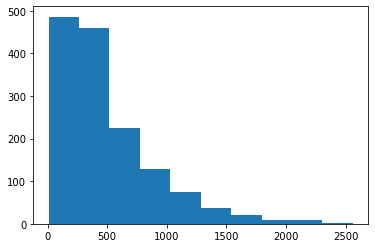

In [80]:
# check deviation
plt.hist(rolling_mean)

In [81]:
# deviation is not standard, let's apply a log

rolling_mean_log = np.log(rolling_mean)

(array([  6.,  18.,  29.,  46., 142., 232., 376., 342., 214.,  47.]),
 array([2.093274  , 2.66880266, 3.24433131, 3.81985996, 4.39538862,
        4.97091727, 5.54644593, 6.12197458, 6.69750324, 7.27303189,
        7.84856054]),
 <BarContainer object of 10 artists>)

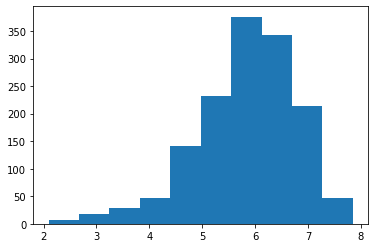

In [82]:
plt.hist(rolling_mean_log)

In [70]:
from statsmodels.tsa.stattools import adfuller

def ADF_Stationarity_Test(timeseries, significance_level):
    result = adfuller(timeseries)
    print(result)
    if result[1] < significance_level:
        print(f'The time series is stationary with a p-value of {result[1]}')
    else:
        print(f'The time series is not stationary with a p-value of {result[1]}')

In [83]:
ADF_Stationarity_Test(rolling_mean_log, 0.05)

(-5.3610495087941565, 4.087271374841935e-06, 15, 1436, {'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}, 1219.7258027488328)
The time series is stationary with a p-value of 4.087271374841935e-06


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

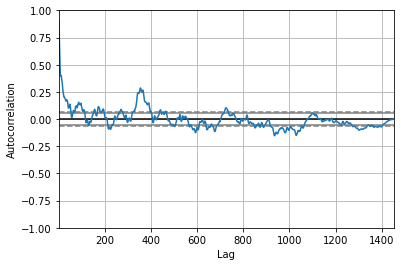

In [88]:
# the time series is stationary, so we can move forward with 
# daily sales had no autocorrelation, so we moved to a 7-day average

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(rolling_mean_log)

# looks like 20, hard to see

In [90]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(rolling_mean, order=(20,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 1452
Model:                ARIMA(20, 1, 0)   Log Likelihood               -9254.635
Date:                Tue, 26 Jul 2022   AIC                          18551.271
Time:                        19:31:54   BIC                          18662.151
Sample:                    01-09-2014   HQIC                         18592.646
                         - 12-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0722      0.021      3.373      0.001       0.030       0.114
ar.L2         -0.0111      0.038     -0.294      0.769      -0.085       0.063
ar.L3          0.0353      0.026      1.347      0.1

NameError: name 'pyplot' is not defined

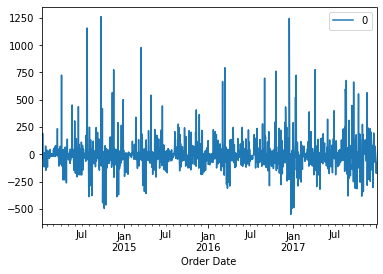

In [92]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

NameError: name 'pyplot' is not defined

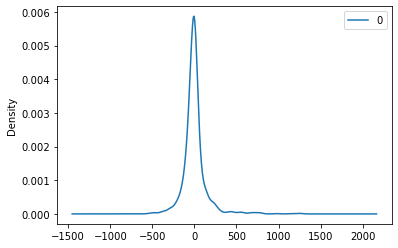

In [93]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

In [94]:
# summary stats of residuals
print(residuals.describe())

                 0
count  1452.000000
mean      0.989157
std     142.362046
min    -549.325939
25%     -50.659340
50%      -6.279802
75%      26.537285
max    1260.651348


In [95]:
# evaluate an ARIMA model using a walk-forward validation
# split into train and test sets
X = rolling_mean.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [96]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=490.367491, expected=495.279143
predicted=490.919362, expected=432.246571
predicted=424.428073, expected=422.881714
predicted=415.608464, expected=489.071143
predicted=502.879595, expected=476.674000
predicted=478.303979, expected=448.301143
predicted=444.313287, expected=172.040000
predicted=171.533926, expected=175.464000
predicted=180.550263, expected=888.806000
predicted=894.187032, expected=932.593571
predicted=929.761569, expected=1072.463857
predicted=1038.274243, expected=1253.070429
predicted=1230.355872, expected=1411.532571
predicted=1435.192204, expected=1416.891429
predicted=1410.023900, expected=1413.467429
predicted=1411.146185, expected=838.166857
predicted=840.652283, expected=749.628714
predicted=759.397954, expected=622.676714
predicted=638.727867, expected=519.716429
predicted=538.071913, expected=373.805143
predicted=358.134379, expected=463.609429
predicted=467.032614, expected=563.536286
predicted=565.500684, expected=564.465143
predicted=562.095039, ex

In [99]:
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Huge improvement over the previous approach

Test RMSE: 208.783


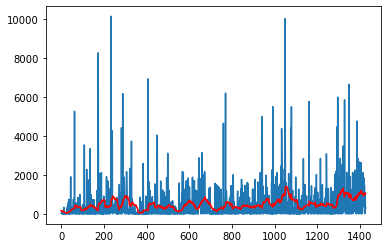

In [102]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Prophet

In [109]:
# import prophet
from prophet import Prophet

In [104]:
prophet = rolling_mean.reset_index()

In [105]:
prophet

,Order Date,Sales
0,2014-01-09,147.022571
1,2014-01-10,145.085714
2,2014-01-11,103.934286
3,2014-01-12,101.143429
4,2014-01-13,292.825714
...,...,...
1447,2017-12-26,1272.969714
1448,2017-12-27,1220.900000
1449,2017-12-28,1123.642000
1450,2017-12-29,899.445857


In [106]:
columns = ['ds', 'y']
prophet.columns = columns
prophet

,ds,y
0,2014-01-09,147.022571
1,2014-01-10,145.085714
2,2014-01-11,103.934286
3,2014-01-12,101.143429
4,2014-01-13,292.825714
...,...,...
1447,2017-12-26,1272.969714
1448,2017-12-27,1220.900000
1449,2017-12-28,1123.642000
1450,2017-12-29,899.445857


In [107]:
prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1452 non-null   datetime64[ns]
 1   y       1452 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.8 KB


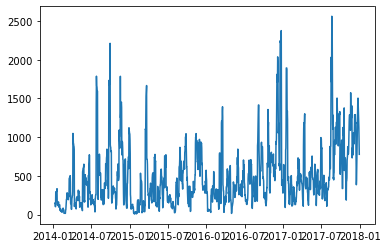

In [108]:
plt.plot(prophet.ds, prophet.y)
plt.show()

In [110]:
model = Prophet()
model.fit(prophet)

19:48:32 - cmdstanpy - INFO - Chain [1] start processing
19:48:33 - cmdstanpy - INFO - Chain [1] done processing


In [112]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
1812,2018-12-26
1813,2018-12-27
1814,2018-12-28
1815,2018-12-29
1816,2018-12-30


In [113]:
forecast = model.predict(future)

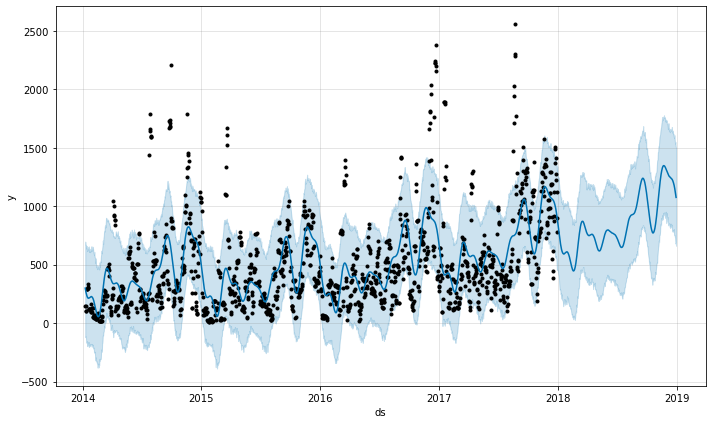

In [115]:
fig = model.plot(forecast)